# COVID 19: Forecasting using ARIMA and LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import warnings

warnings.filterwarnings("ignore")

## Data Sources

In [ ]:
confirmed_df = pd.read_csv("/content/confirmed_df.csv", parse_dates=["Date"])
deaths_df = pd.read_csv("/content/deaths_df.csv", parse_dates=["Date"])
recovered_df = pd.read_csv("/content/recovered_df.csv", parse_dates=["Date"])

In [ ]:
# Dropping Serial Number
confirmed_df.drop(["SNo"], axis=1, inplace=True)
deaths_df.drop(["SNo"], axis=1, inplace=True)
recovered_df.drop(["SNo"], axis=1, inplace=True)

In [ ]:
confirmed_df.head()

,Date,Province/State,Country,Confirmed
0,2020-01-22,Hong Kong,Hong Kong,0.0
1,2020-01-22,Macau,Macau,1.0
2,2020-01-22,Anhui,Mainland China,1.0
3,2020-01-22,Beijing,Mainland China,14.0
4,2020-01-22,Chongqing,Mainland China,6.0


In [ ]:
deaths_df.head()

,Date,Province/State,Country,Deaths
0,2020-01-22,Hong Kong,Hong Kong,0.0
1,2020-01-22,Macau,Macau,0.0
2,2020-01-22,Anhui,Mainland China,0.0
3,2020-01-22,Beijing,Mainland China,0.0
4,2020-01-22,Chongqing,Mainland China,0.0


In [ ]:
recovered_df.head()

,Date,Province/State,Country,Recovered
0,2020-01-22,Hong Kong,Hong Kong,0.0
1,2020-01-22,Macau,Macau,0.0
2,2020-01-22,Anhui,Mainland China,0.0
3,2020-01-22,Beijing,Mainland China,0.0
4,2020-01-22,Chongqing,Mainland China,0.0


In [ ]:
confirmed_world_df = (
    confirmed_df.groupby("Date")["Confirmed"]
    .sum()
    .sort_values(axis="index")
    .reset_index()
)

In [ ]:
recovered_world_df = (
    recovered_df.groupby("Date")["Recovered"]
    .sum()
    .sort_values(axis="index")
    .reset_index()
)

In [ ]:
deaths_world_df = (
    deaths_df.groupby("Date")["Deaths"].sum().sort_values(axis="index").reset_index()
)

## LSTM

In [ ]:
look_back = 1
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i : (i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
def normalize_split(dataset):
    # normalize the dataset
    dataset = scaler.fit_transform(dataset)

    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size : len(dataset), :]

    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    return trainX, trainY, testX, testY

### Confirmed

In [ ]:
(
    confirmed_train_X,
    confirmed_train_Y,
    confirmed_test_X,
    confirmed_test_Y,
) = normalize_split(confirmed_world_df[["Confirmed"]])

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(confirmed_train_X, confirmed_train_Y, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
162/162 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 2/100
162/162 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 3/100
162/162 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 4/100
162/162 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 5/100
162/162 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 6/100
162/162 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 7/100
162/162 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 8/100
162/162 [==============================] - 0s 1ms/step - loss: 8.3876e-04
Epoch 9/100
162/162 [==============================] - 0s 1ms/step - loss: 3.4618e-04
Epoch 10/100
162/162 [==============================] - 0s 1ms/step - loss: 1.1391e-04
Epoch 11/100
162/162 [==============================] - 0s 1ms/step - loss: 3.8619e-05
Epoch 12/100
162/162 [==============================] - 0s 1ms/step - loss: 1.59

In [ ]:
# make predictions
confirmed_train_predict = model.predict(confirmed_train_X)
confirmed_test_predict = model.predict(confirmed_test_X)

# invert predictions
confirmed_train_predict = scaler.inverse_transform(confirmed_train_predict)
confirmed_train_Y = scaler.inverse_transform([confirmed_train_Y])
confirmed_test_predict = scaler.inverse_transform(confirmed_test_predict)
confirmed_test_Y = scaler.inverse_transform([confirmed_test_Y])

# calculate root mean squared error
trainScore = math.sqrt(
    mean_squared_error(confirmed_train_Y[0], confirmed_train_predict[:, 0])
)
print("Train Score: %.2f RMSE" % (trainScore))
testScore = math.sqrt(
    mean_squared_error(confirmed_test_Y[0], confirmed_test_predict[:, 0])
)
print("Test Score: %.2f RMSE" % (testScore))

Train Score: 76353.71 RMSE
Test Score: 2084504.32 RMSE


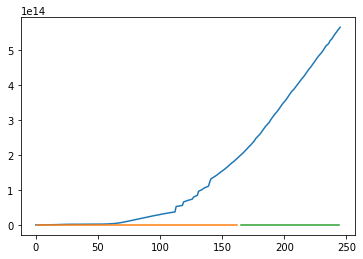

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(confirmed_world_df[["Confirmed"]])
trainPredictPlot[:, :] = np.nan
trainPredictPlot[
    look_back : len(confirmed_train_predict) + look_back, :
] = confirmed_train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(confirmed_world_df[["Confirmed"]])
testPredictPlot[:, :] = np.nan
testPredictPlot[
    len(confirmed_train_predict)
    + (look_back * 2)
    + 1 : len(confirmed_world_df[["Confirmed"]])
    - 1,
    :,
] = confirmed_test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(confirmed_world_df[["Confirmed"]]))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Recovered (world)

In [ ]:
(
    recovered_train_X,
    recovered_train_Y,
    recovered_test_X,
    recovered_test_Y,
) = normalize_split(recovered_world_df[["Recovered"]])

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(recovered_train_X, recovered_train_Y, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
162/162 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 2/100
162/162 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 3/100
162/162 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 4/100
162/162 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 5/100
162/162 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 6/100
162/162 [==============================] - 0s 1ms/step - loss: 9.6613e-04
Epoch 7/100
162/162 [==============================] - 0s 1ms/step - loss: 5.0661e-04
Epoch 8/100
162/162 [==============================] - 0s 1ms/step - loss: 2.2494e-04
Epoch 9/100
162/162 [==============================] - 0s 1ms/step - loss: 8.2003e-05
Epoch 10/100
162/162 [==============================] - 0s 1ms/step - loss: 2.9053e-05
Epoch 11/100
162/162 [==============================] - 0s 1ms/step - loss: 1.3289e-05
Epoch 12/100
162/162 [==============================] - 0s 1ms/step - lo

In [ ]:
# make predictions
recovered_train_predict = model.predict(recovered_train_X)
recovered_test_predict = model.predict(recovered_test_X)

# invert predictions
recovered_train_predict = scaler.inverse_transform(recovered_train_predict)
recovered_train_Y = scaler.inverse_transform([recovered_train_Y])
recovered_test_predict = scaler.inverse_transform(recovered_test_predict)
recovered_test_Y = scaler.inverse_transform([recovered_test_Y])

# calculate root mean squared error
trainScore = math.sqrt(
    mean_squared_error(recovered_train_Y[0], recovered_train_predict[:, 0])
)
print("Train Score: %.2f RMSE" % (trainScore))
testScore = math.sqrt(
    mean_squared_error(recovered_test_Y[0], recovered_test_predict[:, 0])
)
print("Test Score: %.2f RMSE" % (testScore))

Train Score: 41635.19 RMSE
Test Score: 1099354.44 RMSE


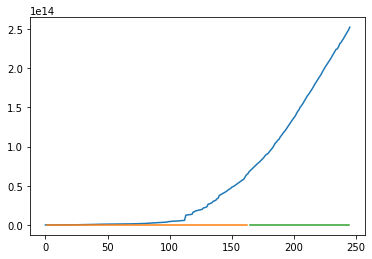

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(recovered_world_df[["Recovered"]])
trainPredictPlot[:, :] = np.nan
trainPredictPlot[
    look_back : len(recovered_train_predict) + look_back, :
] = recovered_train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(recovered_world_df[["Recovered"]])
testPredictPlot[:, :] = np.nan
testPredictPlot[
    len(recovered_train_predict)
    + (look_back * 2)
    + 1 : len(recovered_world_df[["Recovered"]])
    - 1,
    :,
] = recovered_test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(recovered_world_df[["Recovered"]]))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Deaths (world)

In [ ]:
(
    deaths_train_X,
    deaths_train_Y,
    deaths_test_X,
    deaths_test_Y,
) = normalize_split(deaths_world_df[["Deaths"]])

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(deaths_train_X, deaths_train_Y, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
162/162 [==============================] - 0s 1ms/step - loss: 0.0352
Epoch 2/100
162/162 [==============================] - 0s 1ms/step - loss: 0.0262
Epoch 3/100
162/162 [==============================] - 0s 1ms/step - loss: 0.0227
Epoch 4/100
162/162 [==============================] - 0s 1ms/step - loss: 0.0193
Epoch 5/100
162/162 [==============================] - 0s 1ms/step - loss: 0.0148
Epoch 6/100
162/162 [==============================] - 0s 1ms/step - loss: 0.0095
Epoch 7/100
162/162 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 8/100
162/162 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 9/100
162/162 [==============================] - 0s 1ms/step - loss: 2.7077e-04
Epoch 10/100
162/162 [==============================] - 0s 1ms/step - loss: 1.1002e-04
Epoch 11/100
162/162 [==============================] - 0s 1ms/step - loss: 9.7535e-05
Epoch 12/100
162/162 [==============================] - 0s 1ms/step - loss: 9.6761e-

In [ ]:
# make predictions
deaths_train_predict = model.predict(deaths_train_X)
deaths_test_predict = model.predict(deaths_test_X)

# invert predictions
deaths_train_predict = scaler.inverse_transform(deaths_train_predict)
deaths_train_Y = scaler.inverse_transform([deaths_train_Y])
deaths_test_predict = scaler.inverse_transform(deaths_test_predict)
deaths_test_Y = scaler.inverse_transform([deaths_test_Y])

# calculate root mean squared error
trainScore = math.sqrt(
    mean_squared_error(deaths_train_Y[0], deaths_train_predict[:, 0])
)
print("Train Score: %.2f RMSE" % (trainScore))
testScore = math.sqrt(mean_squared_error(deaths_test_Y[0], deaths_test_predict[:, 0]))
print("Test Score: %.2f RMSE" % (testScore))

Train Score: 6711.43 RMSE
Test Score: 57279.40 RMSE


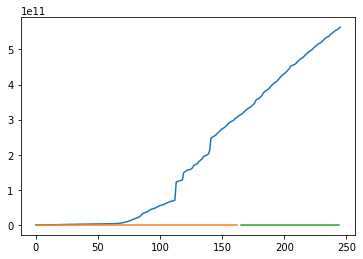

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(deaths_world_df[["Deaths"]])
trainPredictPlot[:, :] = np.nan
trainPredictPlot[
    look_back : len(deaths_train_predict) + look_back, :
] = deaths_train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(deaths_world_df[["Deaths"]])
testPredictPlot[:, :] = np.nan
testPredictPlot[
    len(deaths_train_predict)
    + (look_back * 2)
    + 1 : len(deaths_world_df[["Deaths"]])
    - 1,
    :,
] = deaths_test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(deaths_world_df[["Deaths"]]))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## ARIMA

### Confirmed

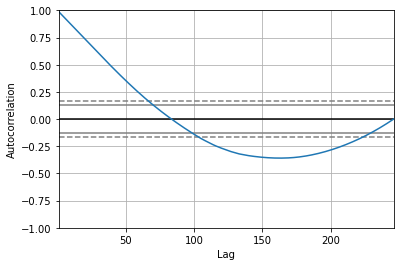

In [ ]:
X = confirmed_world_df[["Confirmed"]].values

autocorrelation_plot(X)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  245
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3087.664
Method:                       css-mle   S.D. of innovations          71780.117
Date:                Thu, 05 Nov 2020   AIC                           6189.328
Time:                        05:42:46   BIC                           6213.837
Sample:                             1   HQIC                          6199.198
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.698e+04   3.16e+04      3.065      0.002     3.5e+04    1.59e+05
ar.L1.D.y      0.2762      0.063      4.376      0.000       0.152       0.400
ar.L2.D.y      0.1250      0.064      1.958      0.0

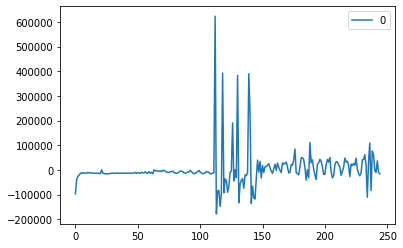

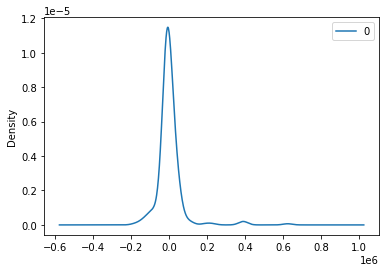

                   0
count     245.000000
mean     1360.556706
std     72060.819472
min   -178248.470059
25%    -13881.054620
50%    -10440.471655
75%     12047.706942
max    623317.685294


In [ ]:
# fit model
model = ARIMA(X, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind="kde")
plt.show()
print(residuals.describe())

In [ ]:
size = int(len(X) * 0.66)
train, test = X[0:size], X[size : len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions, squared=False)
print("Test RMSE: %.3f" % error)

Test RMSE: 44780.589


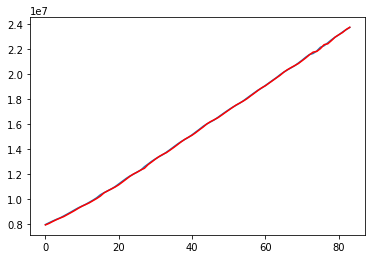

In [ ]:
# plot
plt.plot(test)
plt.plot(predictions, color="red")
plt.show()

### Recovered

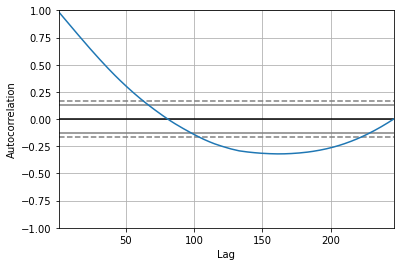

In [ ]:
X = recovered_world_df[["Recovered"]].values

autocorrelation_plot(X)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  245
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2955.226
Method:                       css-mle   S.D. of innovations          41731.813
Date:                Thu, 05 Nov 2020   AIC                           5924.452
Time:                        05:43:04   BIC                           5948.960
Sample:                             1   HQIC                          5934.321
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.483e+04   3.99e+04      1.626      0.105   -1.33e+04    1.43e+05
ar.L1.D.y      0.1355      0.063      2.159      0.032       0.013       0.258
ar.L2.D.y      0.1924      0.062      3.123      0.0

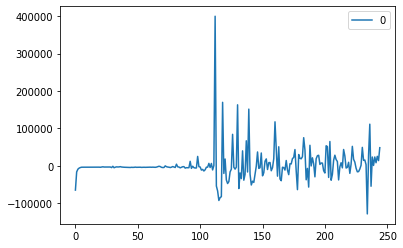

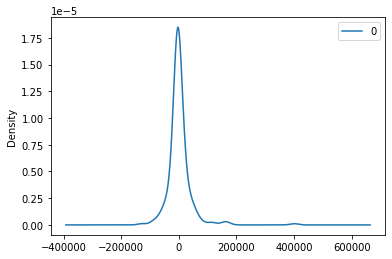

                   0
count     245.000000
mean     1891.235715
std     41927.589450
min   -128529.350403
25%     -6272.328999
50%     -3553.284727
75%      7306.773148
max    400021.089051


In [ ]:
# fit model
model = ARIMA(X, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind="kde")
plt.show()
print(residuals.describe())

In [ ]:
size = int(len(X) * 0.66)
train, test = X[0:size], X[size : len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions, squared=False)
print("Test Root MSE: %.3f" % error)

Test Root MSE: 37252.965


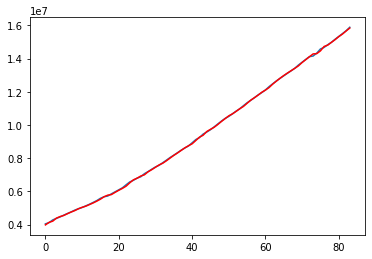

In [ ]:
# plot
plt.plot(test)
plt.plot(predictions, color="red")
plt.show()

### Deaths

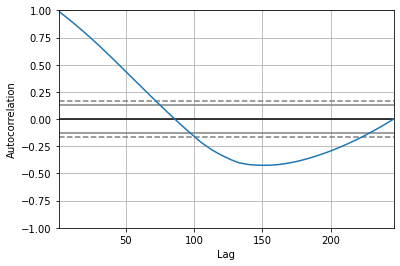

In [ ]:
X = deaths_world_df[["Deaths"]].values

autocorrelation_plot(X)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  245
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2462.193
Method:                       css-mle   S.D. of innovations           5601.140
Date:                Thu, 05 Nov 2020   AIC                           4938.387
Time:                        05:43:23   BIC                           4962.895
Sample:                             1   HQIC                          4948.256
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3061.5227    492.906      6.211      0.000    2095.445    4027.601
ar.L1.D.y      0.1316      0.064      2.068      0.040       0.007       0.256
ar.L2.D.y      0.0460      0.064      0.718      0.4

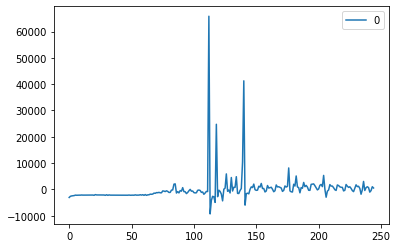

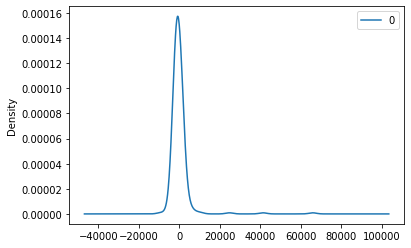

                  0
count    245.000000
mean       3.218396
std     5612.752328
min    -9313.746258
25%    -2124.150469
50%     -674.423460
75%      705.028732
max    65825.824153


In [ ]:
# fit model
model = ARIMA(X, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind="kde")
plt.show()
print(residuals.describe())

In [ ]:
size = int(len(X) * 0.66)
train, test = X[0:size], X[size : len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions, squared=False)
print("Test Root MSE: %.3f" % error)

Test Root MSE: 1772.411


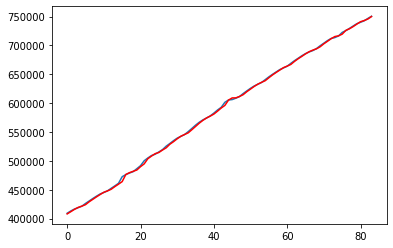

In [ ]:
# plot
plt.plot(test)
plt.plot(predictions, color="red")
plt.show()

RMSEs:


*   Prophet: 937359.72
*   LSTM: 79527.91
*   ARIMA: 27,935.321



